# Chapter 7

## 7.1 The problem with parameters
## 7.2 Accuracy and Entropy
## 7.3 Regularization
## 7.4 Predicting Predictive Accuracy
## 7.5 Model comparison

## Intro
+ BERKSON'S PARADOX / SELECTION-DISTORTION EFFECT
+ Example below. Study proposals go to a committee, who rank on newsworthiness and trustworthiness. Each study gets an equally weighted rating assigned to newsw. and trustw., and tallies up the scores. Studies with highest scores are selected to go forward
+ Later someone does an analysis of studies and finds that newsworthiness and trustworthiness are negatively correlated
+ In the initial proposals, there was no correlation, but after selection there was.
+ This can happen with a multiple linear regression if we just keep adding variables. It iduces statistical selection inside the model - COLLIDER BIAS
![alt text](images/6/newsworthiness-trustworthiness.png "Title")

+ lecture 5 Link
    + https://www.youtube.com/watch?v=UpP-_mBvECI
    + Collider section at 40:34


In [1]:
suppressMessages({
library(rethinking)
library(dagitty)
    })

# 6.1 Multicollinearity
+ Why not add all varaibles to multiple linear regression? Because Multicollinearity
+ Multicollinearity means strong association between variables. 
+ Important problem is association conditional on other variables in the model.
+ Posterior distribution will suggest none of variables are reliably associated with the outcome, even if all are associated with the outcome.
+ BUT, the model will work fine for prediction!!!
+ You will not be able to understand the model

## 6.1.1 Multicollinear legs
+ Predict height from leg length. Use left and right leg length - (very slightly different)

In [2]:
set.seed(909)
N <- 100 # N people
height <-rnorm(N, 10, 2) # Simulate height of N people, mean 10, stdev 2
leg_prop <- runif(N, 0.4, 0.5) # Simulate leg length as 0.4 to 0.5 proportion of height
left_leg <- (leg_prop * height) + rnorm(N, 0, 0.02) # sim l leg with error
right_leg <- (leg_prop * height) + rnorm(N, 0, 0.02) # sim l leg with error
d <- data.frame(height, left_leg, right_leg)
str(d)

'data.frame':	100 obs. of  3 variables:
 $ height   : num  5.93 6.51 9.35 9.23 10.36 ...
 $ left_leg : num  2.68 2.68 3.93 3.96 4.43 ...
 $ right_leg: num  2.71 2.68 3.98 3.99 4.42 ...


In [3]:
m6.1 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + bl*left_leg + br*right_leg,
        a ~ dnorm(0, 100),
        bl ~ dnorm(2, 10),
        br ~ dnorm(2, 10),
        sigma ~ dexp(1)
    ), data=d)
precis(m6.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9811156,0.2839607,0.5272915,1.4349396
bl,0.2138054,2.5270797,-3.8249560,4.2525669
br,1.7817631,2.5312933,-2.2637325,5.8272587
sigma,0.6171141,0.0434363,0.5476945,0.6865337


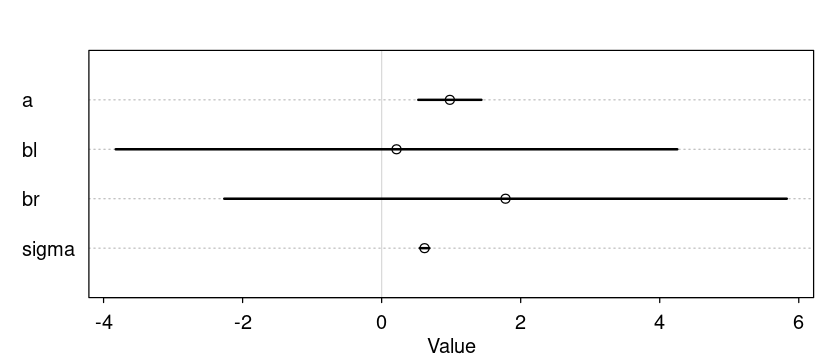

In [4]:
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.1))

+ `Those posterior means and standard deviations look crazy` - I need a bit more help than that!
+ I guess the standard deviations for bl and br are higher than the mean. Not sure what else to look for here?
+ `What is the value of knowing each predictor, after already knowing all of the other predictors?` - so what is the value of knowing say the right leg length after knowing the right leg length
+ Plot the posterior distributions of bl and br against each other. These are very very strongly correlated. When bl is small, br must be big. 

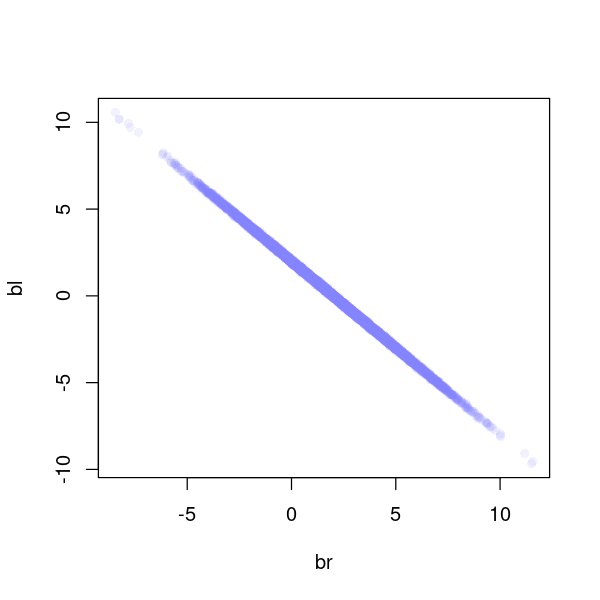

In [5]:
options(repr.plot.width=5, repr.plot.height=5)
post <- extract.samples(m6.1)
plot( bl ~ br , post , col=col.alpha(rangi2,0.1) , pch=16 )

+ The model is like this:
    + $y_i \sim Normal(\mu_i, \sigma)$
    + $\mu_i = \alpha + \beta_1x_i + \beta_2x_i$
    + where:
        + x is a single predictor
+ But that is the like this:    
    + $\mu_i = \alpha + (\beta_1 + \beta_2)x_i$
+ The posterior is giving us back the sum of $\beta_1$ and $\beta_2$

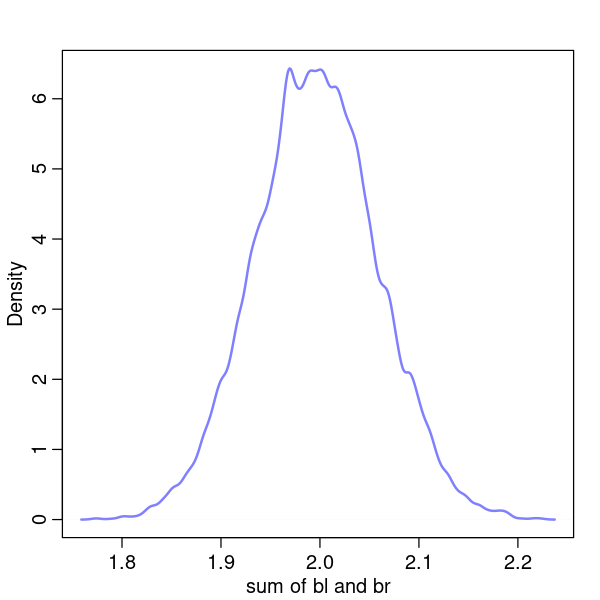

In [6]:
sum_blbr <- post$bl + post$br
dens(sum_blbr, col=rangi2, lwd=2, xlab="sum of bl and br")

+ Now fit regression using a single leg length

In [7]:
m6.2 <- quap(
 alist(
  height ~ dnorm(mu, sigma),
  mu <- a + bl*left_leg,
  a ~ dnorm(10, 100),
  bl ~ dnorm(2, 10),
  sigma ~ dexp(1)
 ) , data=d)

precis(m6.2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9979326,0.28364620,0.5446112,1.451254
bl,1.9920676,0.06115704,1.8943269,2.089808
sigma,0.6186038,0.04353998,0.5490185,0.688189


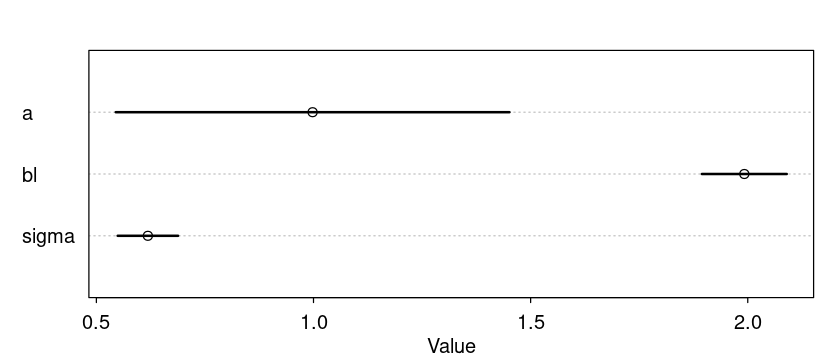

In [8]:
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.2))

+ takeaway
+ When 2 predictors are highly correlated (conditional on other variables in the model) - What does this mean? - including both will be confusing.
+ Strictly the model output will be correct, but interpretability will be lacking
+ The risk is that we include highly correlated variables in the model, and the model tells us neither is important.

### 6.1.2 Multicollinear milk
+ Predict calories in milk from percentage lactose, and % fat

In [9]:
library(rethinking)
data(milk)
d <- milk
d$K <- standardize(d$kcal.per.g)
d$F <- standardize(d$perc.fat)
d$L <- standardize(d$perc.lactose)

[1] "K is target"


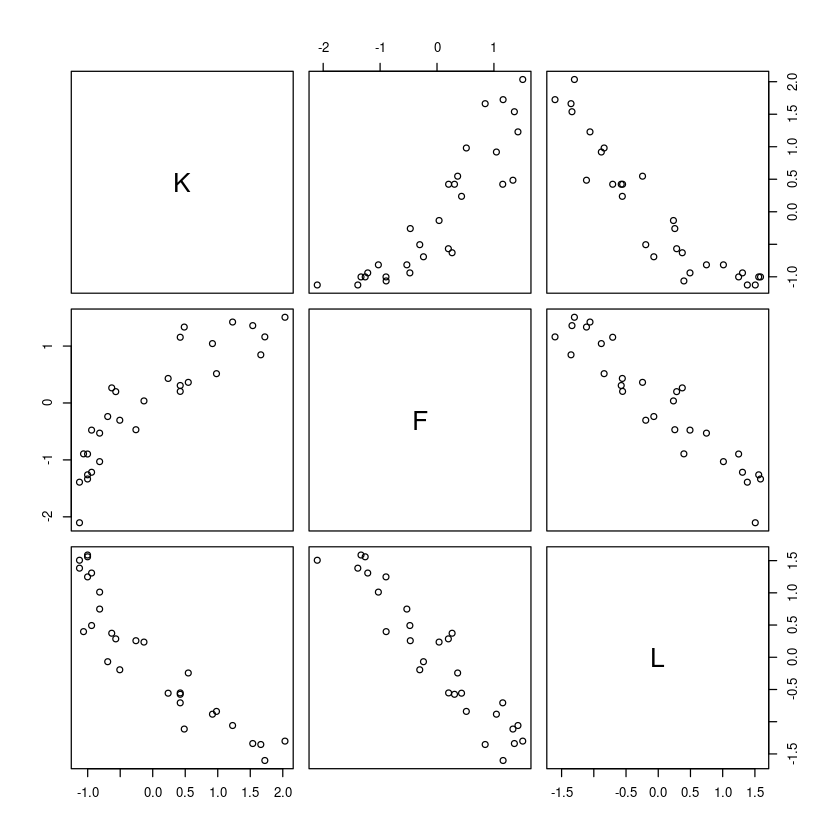

In [10]:
options(repr.plot.width=7, repr.plot.height=7)
# pairs(d[, d$K, d$F, d$L])
pairs(d[, c("K", "F", "L")])
print('K is target')

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.535526e-07,0.07725195,-0.1234634,0.1234637
bF,8.618970e-01,0.08426088,0.7272318,0.9965621
sigma,4.510179e-01,0.05870756,0.3571919,0.5448440


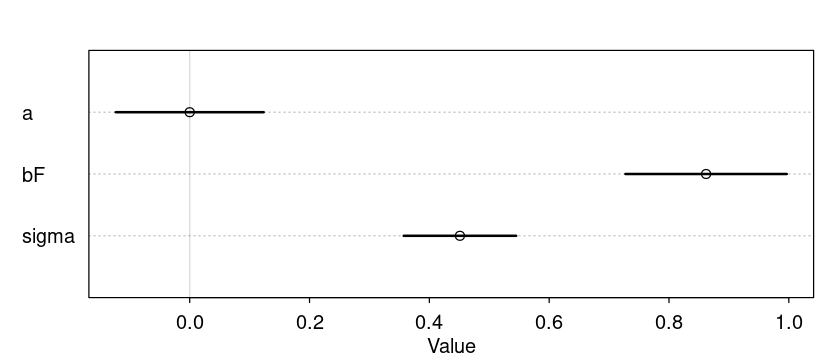

In [11]:
# kcal.per.g regressed on perc.fat
m6.3 <- quap(
 alist(
  K ~ dnorm(mu, sigma),
  mu <- a + bF*F,
  a ~ dnorm(0, 0.2),
  bF ~ dnorm(0, 0.5),
  sigma ~ dexp(1)
 ) , data=d )
precis(m6.3)
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.3))

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,7.438895e-07,0.06661633,-0.1064650,0.1064665
bL,-9.024550e-01,0.07132848,-1.0164517,-0.7884583
sigma,3.804653e-01,0.04958259,0.3012227,0.4597078


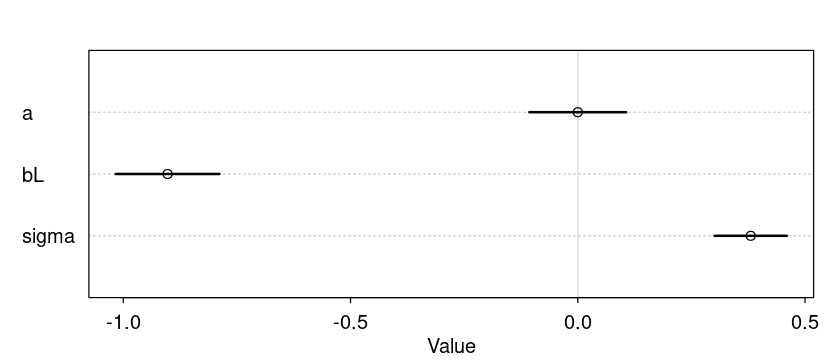

In [12]:
# kcal.per.g regressed on perc.lactose
m6.4 <- quap(
 alist(
  K ~ dnorm(mu, sigma),
  mu <- a + bL*L,
  a ~ dnorm(0, 0.2),
  bL ~ dnorm(0, 0.5),
  sigma ~ dexp(1)
 ) , data=d )
precis(m6.4)
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.4))

+ Using both variables in the same model

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-3.172136e-07,0.06603577,-0.10553823,0.1055376
bF,2.434983e-01,0.18357865,-0.04989579,0.5368925
bL,-6.780825e-01,0.18377670,-0.97179320,-0.3843719
sigma,3.767418e-01,0.04918394,0.29813637,0.4553472


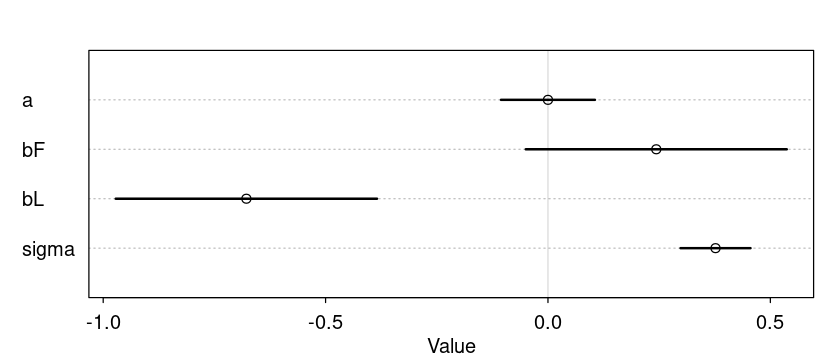

In [13]:
m6.5 <- quap(
 alist(
  K ~ dnorm(mu, sigma),
  mu <- a + bF*F + bL*L,
  a ~ dnorm(0, 0.2),
  bF ~ dnorm(0, 0.5),
  bL ~ dnorm(0, 0.5),
  sigma ~ dexp(1)
 ) , data=d)

precis(m6.5)
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.5))

+ Easier to see on the plot than author's description
+ Standard deviations of $\beta$s are much bigger

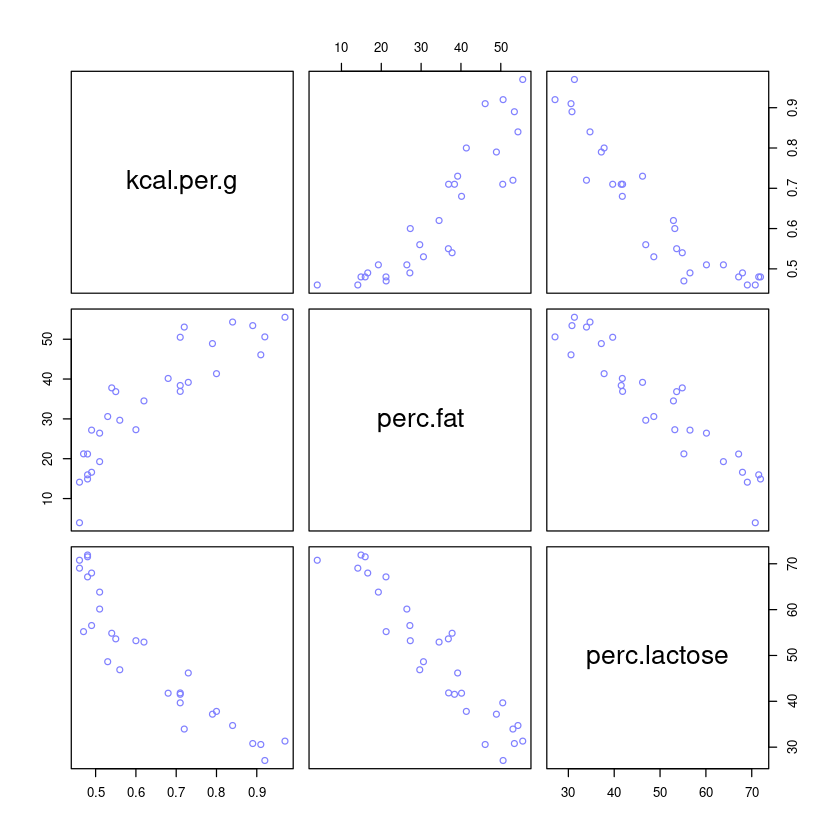

In [14]:
options(repr.plot.width=7, repr.plot.height=7)
pairs( ~ kcal.per.g + perc.fat + perc.lactose , data=d , col=rangi2 )

+ takeaway
+ `Either helps in predicting kcal.per.g, but neither helps as much once you already know the other.`
+ WRONG APPROACH
    + inspect pairwise correlations prior to fitting a model and drop one side of highly correlated predictors
    + This is wrong because correlations do not matter - Conditional association matters
+ With the milk, there is likely a tradeoff between fat and lactose (lactose = sugar)
+ The causal model looks like:

![alt text](images/6/milk-causal-model.png "Title")

+ Tradeoff is D - Density - This is unobserved
+ If we could measure D, that would be a better causal model
+ NON-IDENTIFIABILITY - Parameter is not identified - the model structure means the variable's parameter cannot be estimated
+ If there is not much information in the data, then the posterior distribution will be similar to the prior. Can use this to gauge how much the model is helping us.
+ Simulation below (As per usual there is no title and the axes are labeled in the most minimal way possible)
+ Impreciseness of predictor (standard deviation) gets bigger as association between variables get bigger

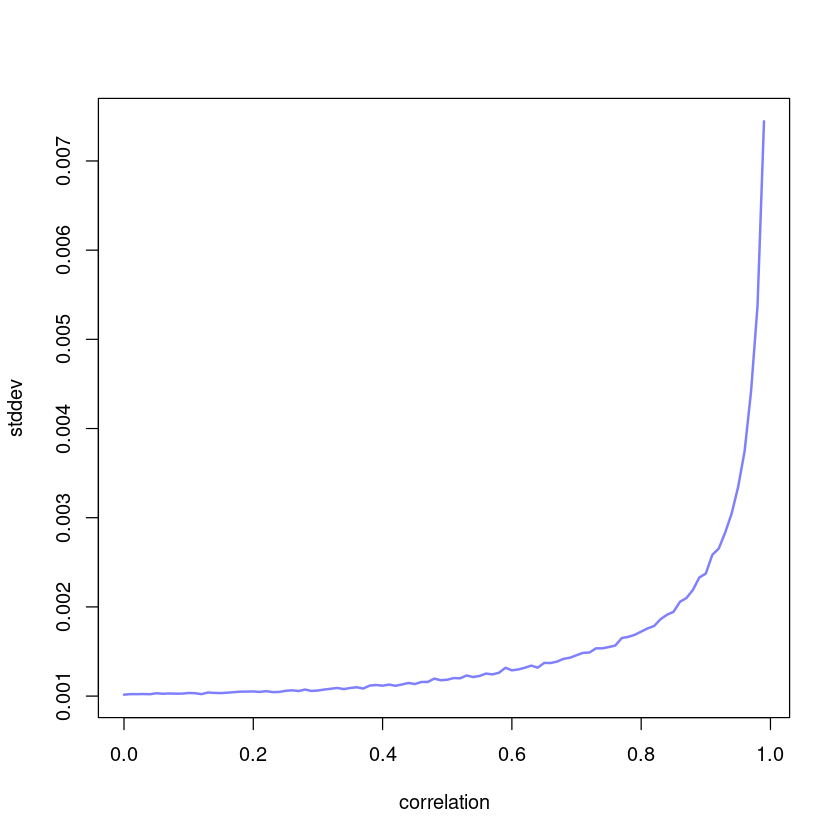

In [15]:
data(milk)
d <- milk
sim.coll <- function( r=0.9 ) {
 d$x <- rnorm( nrow(d) , mean=r*d$perc.fat ,
  sd=sqrt( (1-r^2)*var(d$perc.fat) ) )
 m <- lm( kcal.per.g ~ perc.fat + x , data=d )
 sqrt( diag( vcov(m) ) )[2] # stddev of parameter
}
rep.sim.coll <- function( r=0.9 , n=100 ) {
 stddev <- replicate( n , sim.coll(r) )
 mean(stddev)
}
r.seq <- seq(from=0,to=0.99,by=0.01)
stddev <- sapply( r.seq , function(z) rep.sim.coll(r=z,n=100) )
plot( stddev ~ r.seq , type="l" , col=rangi2, lwd=2 , xlab="correlation")

# 6.2 Post Treatment Bias

+ Missing variables that influence an outcome - OMITTED VARIABLE BIAS
+ The other way can also be a problem - INCLUDED VARIABLE BIAS Forms of this are:
    + POST-TREATMENT BIAS
+ Example problem setup:
    + Growing plants in greenhouse and conduct experiment on growth and fungus
    + Experiment purpose is to understand the difference in growth between plants under a set variety of **anti-fungal treatments.**
    + Note that the treatment is NOT a combination of nutrients and anti-fungal chemicals. **It is purely an anti-fungal treatment.** 
    + We know that more heavily fungused plants tend to grow less [I think the book says this]
    + Experiment process
        + Plants are seeded and sprout [I guess this has to be simultaneous]
        + Heights are measured - $h_0$
        + Plants are [randomly] split into n groups
        + Different soil treatments are applied to each group
        + After set period of time, final measurements are taken:
            + final height $h_1$
            + presence of fungus - binary variable for each plant $fungus$
    + Summarizing the variables:
        + Total number of plants $N$ = 100 
        + Number of plants in each group is N/2 = 50
        + Initial plant height $h_0$ - continuous
        + Anti-fungal treatment applied $treatment$ - discrete, binary:- treatment applied/treatment not applied
        + Final height $h_1$ - continuous
        + Presence of fungus [at time of final height measurement] $fungus$ discrete, binary:- has fungus/does not have fungus
            

In [16]:
# R code 6.13
set.seed(71)
# number of plants
N <- 100
# Initial heights normally distributed withg mean 10, sd = 2
h0 <- rnorm(N, 10, 2)
# Assign treatments
treatment <- rep(0:1, each=N/2)
# Assign the fungus to the treatments
# probability of fungus = 0.5 - treatment * 0.4
# For non treated prob(fungus) = 0.5
# For treated prob(fungus) = 0.5-0.4 = 0.10
fungus <- rbinom(N, size=1, prob=0.5-treatment*0.4)
# docs: rnorm(n, mean = 0, sd = 1)
# Final height = initial height + random sample from normal distribution with sd=1 and [I think] mean at:
# non fungus plant change in height: 5-3*0 -> normally distributed mean=5, sd=1
# fungus plant change in height: 5-3*1 -> normally distributed mean=3, sd=1
h1 <- h0 + rnorm(N, 5-3*fungus)
# make df
d <- data.frame(h0=h0, h1=h1, treatment=treatment, fungus=fungus)
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
h0,9.95978,2.1011623,6.570328,13.07874,▁▂▂▂▇▃▂▃▁▁▁▁
h1,14.39920,2.6880870,10.618002,17.93369,▁▁▃▇▇▇▁▁
treatment,0.50000,0.5025189,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇
fungus,0.23000,0.4229526,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▂


### Setting prior
+ We are fairly sure that final height >= initial height (should be)
+ If we consider the height data in terms of the **proportion** of initial height, this makes setting the priors easier.
+ For heights alone, linear model looks like:
    + $h_{1,i} \sim Normal(\mu_i, \sigma)$
    + $\mu_i = h_{0,i} \times p$
    + where:
        + $h_{0,i}$ - plant i's initial height
        + $h_{1,i}$ - plant i's final height
        + $p = \frac{h_{1,i}}{h_{0,i}}$
            + If p = 1, the plant has not grown
            + if p = 2, the height has doubled
        + We need a prior for p
            + if we center the prior on 1, then we are implying no height change
            + If we allow p to encompass values < 1, then we are considering the scenario where we stunt, or kill the plant
            + We have to ensure p > 0, because it is a proportion
            + All this means a good candidate for the prior is a log-normal distribution because it is always positive
            + Try $p \sim LogNormal(0, 0.25)$    

In [17]:
sim_p <-rlnorm(10000, 0, 0.25)
precis(data.frame(sim_p))

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
sim_p,1.03699,0.2629894,0.670683,1.496397,▁▁▃▇▇▃▁▁▁▁▁▁


+ Interpreting this prior:
    + The author uses 5.5% to 94.5% interval to check the reasonableness of distributions
    + The 95% interval of p is from about 0.7, to 1.5 - so from 30% shorter to 50% bigger than the initial height
+ Code the partial model to see how it measures growth

In [18]:
# R Code 6.15
m6.6 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0*p,
        p ~ dlnorm(0, 0.25),
        sigma ~ dexp(1)
    ), data=d)
precis(m6.6)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
p,1.426626,0.01760992,1.398482,1.454770
sigma,1.793286,0.12517262,1.593236,1.993336


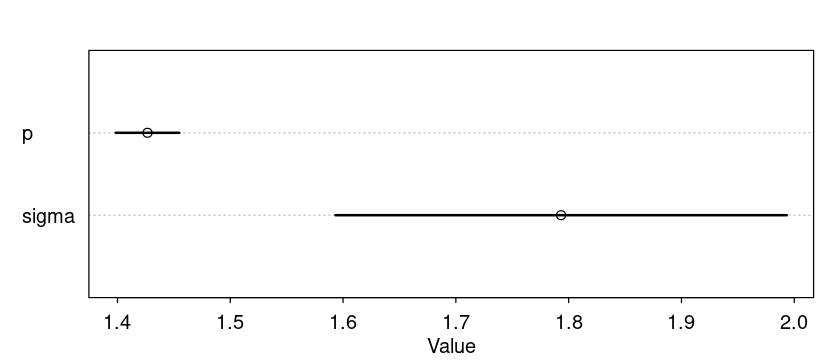

In [19]:
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.6))

+ This means the average proprtion change in height is about 1.4, so about 40% bigger than the initial plant
+ The 40% is across all treatments, and all fungus/no fungus plants
+ Modify the model to include treatment and fungus variables
+ The Treatment and the Fungus are now set up to impact **Change in proportion p**
    + The priors are setup the same as normalized/scaled/standardized [? - should find correct terminolgy for this] priors
    + Think about this trick to make prior estimation feasible? - Without this, I'm not sure where to even start on estimating priors 
    + This looks a bit like magic. need to think about this. can p go negative with this scheme?
+ Model looks like:
    + $h_{1,i} \sim Normal(\mu_i, \sigma$
    + $\mu_i = h_{0,i} \times p$
    + $p = \alpha + \beta_TT_i + \beta_FF_i$
    + $\alpha \sim LogNormal(0, 0.25)$
    + $\beta_T \sim Normal(0, 0.5)$
    + $\beta_F \sim Normal(0, 0.5)$
    + $\sigma \sim Exponential(1)$

In [20]:
# R code 6.16
m6.7 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment + bf*fungus,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        bf ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d)
precis(m6.7)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.481391468,0.02451069,1.44221865,1.52056429
bt,0.002412222,0.02986965,-0.04532525,0.05014969
bf,-0.266718915,0.03654772,-0.32512923,-0.20830860
sigma,1.408797442,0.09862070,1.25118251,1.56641237


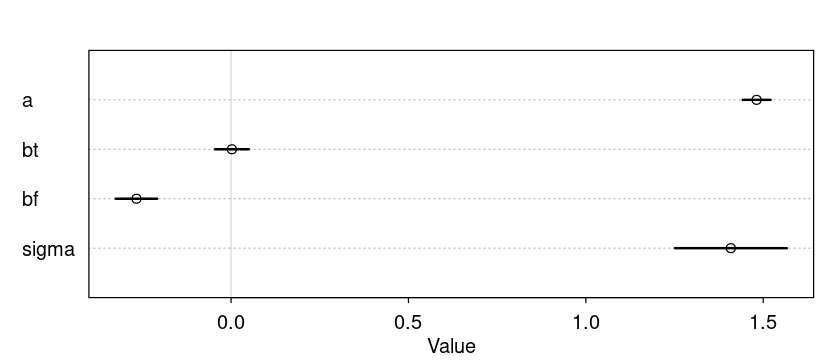

In [21]:
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.7))

+ The alpha parameter is about the same as we got for p
+ This says that treatment has no impact on growth. It is 0 or very small, so it has negligible impact in the linear equation
+ The fungus has a negative coefficient, so it hurts growth
+ Is this model correct?
+ We know fungus is mostly a consequence of treatment
+ We call this  post-treatment variable - it's presence is a consequence of the treatment
+ This means the model is answering:
    + **Once we know whether a plant developed fungus, does treatment matter?**
+ The answer to this question is NO, because the treatment works by reducing fungus, hence allowing more growth
+ Actually our intention was to find the impact of treatment on growth
+ The model changes to:
    + $h_{1,i} \sim Normal(\mu_i, \sigma)$
    + $\mu_i = h_{0,i} \times p$
    + $p = \alpha + \beta_TT_i$
    + $\alpha \sim LogNormal(0, 0.25)$
    + $\beta_T \sim Normal(0, 0.5)$
    + $\sigma \sim Exponential(1)$

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.38035767,0.02517554,1.34012229,1.4205931
bt,0.08499924,0.03429718,0.03018573,0.1398128
sigma,1.74631655,0.12191552,1.55147200,1.9411611


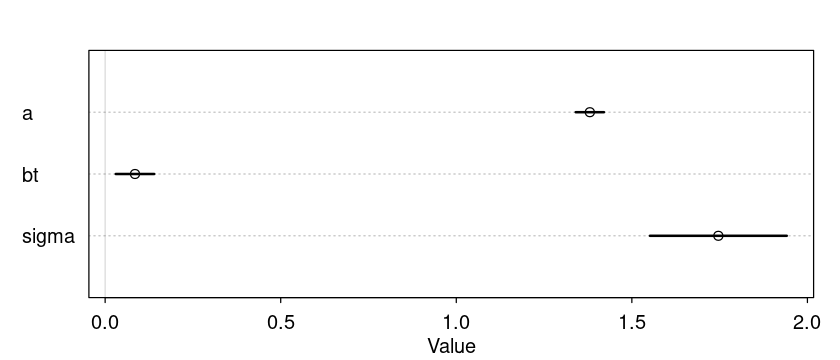

In [22]:
# R code 6.17
m6.8 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d )
precis(m6.8)
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.8))

+ In this model, treatment has a positive impact - this is what we expect
+ The lesson is: Including post-treatment variables, can mask the causal influence of treatment.
+ 6.2.3 d-seperation

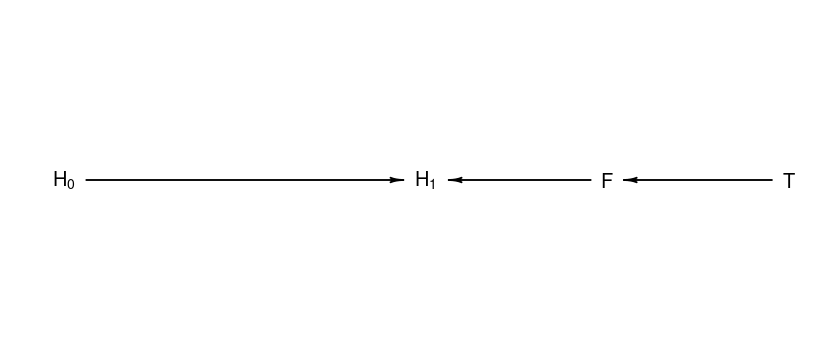

In [23]:
# R code 6.18
plant_dag <- dagitty( "dag {
    H_0 -> H_1
    F -> H_1
    T -> F}")
coordinates( plant_dag ) <- list( x=c(H_0=0,T=2,F=1.5,H_1=1) , y=c(H_0=0,T=0,F=0,H_1=0) )
drawdag(plant_dag)

+ The treatment $T$ influences fungus presence $F$
+ The fungus $F$ influences final height $H_1$
+ The starting height $H_0$ inflences final_height $H_1$
+ When we include $F$ in the model, we block the path between treatment $T$ and outcome $H_1$
+ Known as **D-SEPARATION** (means DIRECTIONAL-SEPARATION). Where some varibales on the DAG are independent of others. There is no path connecting them. $H_1$ is d-separated from $T$, but only when we condition on $F$
+ Conditioning on $F$ blocks the path $T$ -> $F$ -> $H_1$ making $T$ and $H_1$ independent.
+ There is no information in $T$ about $H_1$ that is not also in $F$. So when we know $F$, learning $T$ provides no additional information about $H_1$
+ Querying the implied conditional dependencies for this DAG gives:

In [24]:
impliedConditionalIndependencies(plant_dag)

F _||_ H_0
H_0 _||_ T
H_1 _||_ T | F

+ Interpreting this output:
    + $H_0$ should not be associated with $F$ - Original height not associated with Fungus
    + $T$ should not be associated with $H_0$ - Original height not associated to treatment
    + $H_1$ should not be associated with $T$ if we condition on $F$ - Final height should not be associated with treatment if we condition on fungus
+ This problem of post-treatement variables can also arise in observational studies, as well as experiments, but can be harder to spot.
+ In the example above, conditioning on a post-treatment variable made us think the treatment DOES NOT work.
+ It can also make us think an ineffective treatment DOES work. Consider this DAG

![alt text](images/6/moisture-dag.png "Title")

+ where:
    + $H_0$ - Height at start
    + $H_1$ - height at end
    + $F$ - Fungus
    + $T$ - Treatement
    + $M$ - Moisture UNOBSERVED
+ Treatment influences Fungus
+ Fungus does not influence plant growth
+ Moisture influences Fungus and Plant Growth
+ Regression of $H_1$ on $T$ will show no association
+ Regression of $H_1$ on $T$ and $F$ will show association

In [25]:
# Setup the new data based on the DAG with the Unobserved variable $M$ - Moisture
set.seed(71)
N <- 1000
h0 <- rnorm(N,10,2)
treatment <- rep(0:1, each=N/2)
M <- rbern(N)
fungus <- rbinom(N, size=1, prob=0.5 - treatment*0.4 + 0.4*M)
h1 <- h0 + rnorm(N, 5 + 3*M)
d2 <- data.frame(h0=h0, h1=h1, treatment=treatment, fungus=fungus)

+ Regress $H_1$ on $F$ AND $T$

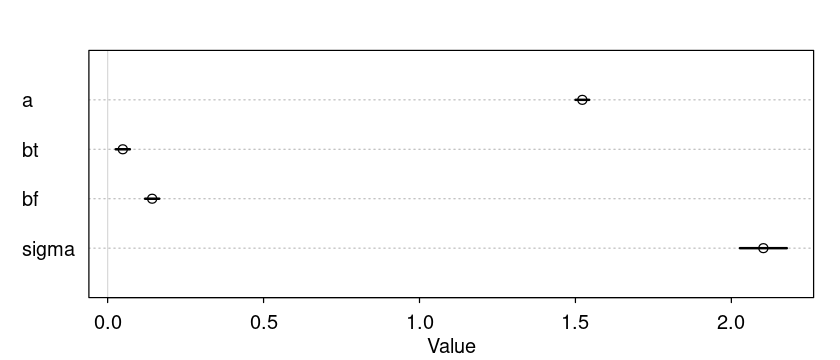

In [26]:
# Regress on Treatment and fungus
m6.7 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment + bf*fungus,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        bf ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d2)
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.7))

+ Conclusions from this (erroneous) model
    + **Treatment has a small positive impact**
    + Fungus has a larger positive impact

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.62401319,0.009546625,1.60875584,1.63927054
bt,-0.01051596,0.013511945,-0.03211066,0.01107874
sigma,2.20520300,0.049231869,2.12652096,2.28388504


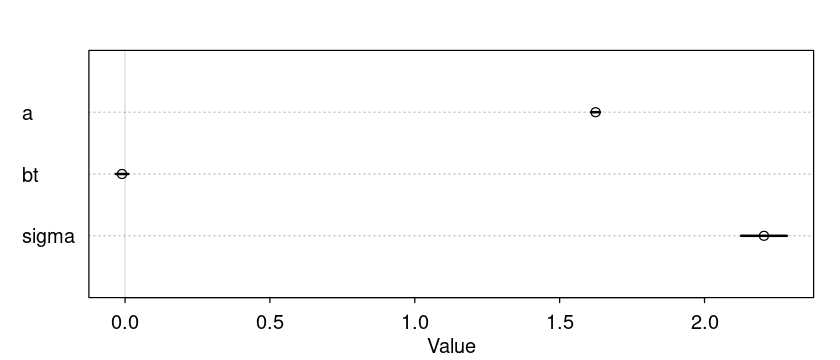

In [27]:
m6.8 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d2)
precis(m6.8)
options(repr.plot.width=7, repr.plot.height=3)
plot(precis(m6.8))

+ Conclusions from this (correct) model
    + **Treatment has a zero impact, or small negative impact on growth**
+ ### In relation to Model Selection
    + Model selection does not help solve this problem
    + The erronous model fits the data better and makes better out-of-sample predictions
    + [I cannot agree with the statement above - the author assumes that the out-of sample data used for predictions includes fungus. This is not right. If the out of sample data is setup the right way, there will be no information about fungus in the out-of sample X variables. This information can only be known at the end of the experiment. But we make predictions based on what we know at the start of the experiment - So, I think his statement is a bit misleading]

# 6.3 Collider Bias

![alt text](images/6/t-s-n.png "Title")

+ Two arrows pointing to $S$ means it is a collider
+ Conditioning on a collider creates statistical (not causal) associations between causes
+ Once you learn a study has been SELECTED S, then learning about it's TRUSTWORTHINESS T, also provides information about it's NEWSWORTHINESS N (See explanation at top of Notebook)
+ But, this collider setup is misleading even if we include the collider $S$ as a predictor variable! Example Below:
+ How does Aging $A$ influence Happiness $H$? This example shows how controlling for a plausible confound of happiness can make an erroneous causal inference
+ Setup
    + Happiness is set at birth - does not change over life
    + Happiness influences life events, in that happier is more likely to lead to marriage
    + Also higher age is more likely to lead to marriage, because more marriage opportunities have occurred.
    + The DAG looks like:
    + ![alt text](images/6/h-m-a.png "Title")
    + Marriage is a Collider
    + There is no causal relationship between happiness and age
    + Including marriage may lead us to an opposite conclusion - that happiness changes with age
+ Data Simulation
    + ![alt text](images/6/sim.png "Title")
    + Happiness fixed at birth
    + Marriage starts after age 18
    + Life ends at 65
    + Marriage increses with age
    + Happier people more likely to get married
    + Just by inspecting the simulation we see:
        + Consider married people (blue dots only) - Older people have lower average happiness
        + Consider unmarried. Older people have lower average happiness
        + In both married and unmarried, happiness declines with age
        + But this is in no way related to causation.
+ The (erroneous) Linear Model:
    + $H ~ Norm(\mu, \sigma)$
    + $\mu_i = \alpha_{MID|i|} + \beta_A \times A_i$
    + $\alpha_{MID} ~ Normal(0, 1)$
    + $\beta_A ~ Normal(0,2)$
    + $\sigma ~ Exp(1)$
    + where:
        + $MID|i|$ is an index for married status. Easier to make priors when we have multiple intercepts - one for each category
+ Coding the model:

In [28]:
# R code 6.21
library(rethinking)
d <- sim_happiness( seed=1977 , N_years=1000 )
# R code 6.22
d2 <- d[d$age>17,] # only 18 and >18
# Rescale so 18 to 65 covers a single unit, so 65 = 1, 18=0 42 = 0.51
d2$A <- (d2$age -18) / ( 65 - 18 )
d2$A[0:5]
precis(d2)

[1] 1 1 1 1 1

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
age,4.150000e+01,13.8606201,20.00000000,63.0000000,▃▇▇▇▇▇▇▇▇▇
married,4.072917e-01,0.4915861,0.00000000,1.0000000,▇▁▁▁▁▁▁▁▁▅
happiness,-1.000070e-16,1.2145867,-1.78947368,1.7894737,▇▅▇▅▅▇▅▇
A,5.000000e-01,0.2949068,0.04255319,0.9574468,▇▇▇▅▇▇▅▇▇▇


+ Setting the priors
    + Happiness is on an arbitrary scale -2 to + 2
    + The age is rescaled so it covers one unit 65 = 1, 18=0, 42 = 0.51
    + The strongest possible relationship taking happiness from min to max is 4 / 1 unit = 4. ie someone goes from minimal happiness to maximum happiness between 18 and 65
    + [? Why is this the strongest relationship? Why can't someone get to minimum to maximum happiness over 5 years, 10 years, 20 years ie. why not consider steeper slopes]
    + If we set the stdev to half of 4 ie 2, we expect 95% of plausible slopes to be less than the strongest (because +/- 2 stdevs covers 95% of a normal distribution) 
    + Setup the married variable, so it is no longer ab indicator by adding 1

In [29]:
# Setup the married variable, so it is no longer ab indicator by adding 1
d2$mid <- d2$married + 1
str(d2)

'data.frame':	960 obs. of  5 variables:
 $ age      : num  65 65 65 65 65 65 65 65 65 65 ...
 $ married  : num  0 0 1 0 0 0 1 1 0 0 ...
 $ happiness: num  -2 -1.79 -1.58 -1.37 -1.16 ...
 $ A        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ mid      : num  1 1 2 1 1 1 2 2 1 1 ...


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.2350877,0.06348986,-0.3365568,-0.1336186
a[2],1.2585517,0.08495989,1.1227694,1.3943340
bA,-0.7490274,0.11320112,-0.9299447,-0.5681102
sigma,0.9897080,0.02255800,0.9536559,1.0257600


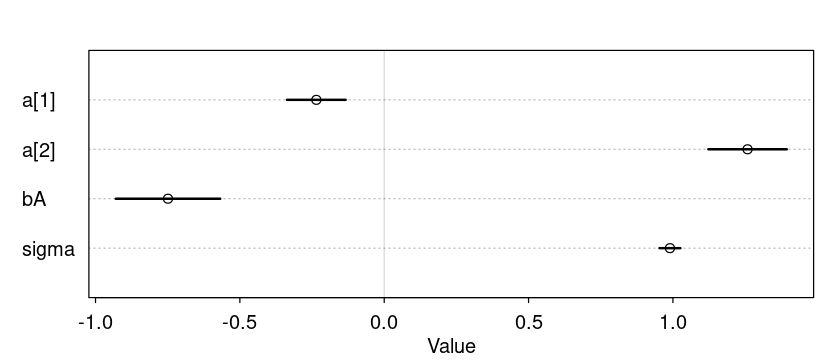

In [30]:
# R code 6.23
m6.9 <- quap(
 alist(
  happiness ~ dnorm(mu, sigma),
  mu <- a[mid] + bA*A,
  a[mid] ~ dnorm(0, 1),
  bA ~ dnorm(0, 2),
  sigma ~ dexp(1)
 ) , data=d2 )

precis(m6.9,depth=2)
plot(precis(m6.9,depth=2))

+ The model parameter `bA` concludes that as age gets bigger happiness reduces
+ A model omitting Marriage

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.649248e-07,0.07675015,-0.1226614,0.1226617
bA,-2.728620e-07,0.13225976,-0.2113769,0.2113764
sigma,1.213188e+00,0.02766080,1.1689803,1.2573949


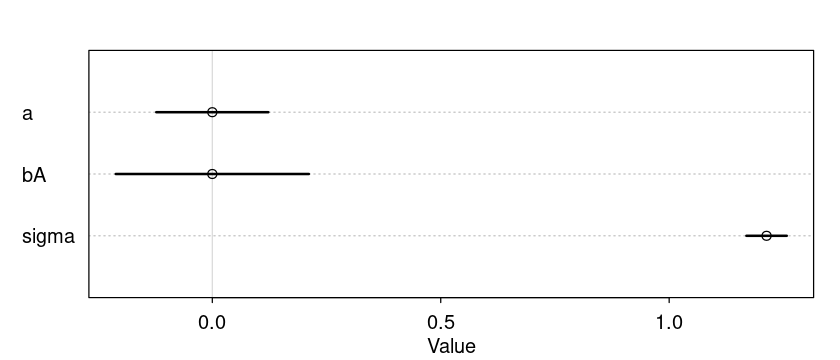

In [31]:
m6.10 <- quap(
 alist(
  happiness ~ dnorm(mu, sigma),
  mu <- a + bA*A,
  a ~ dnorm(0, 1),
  bA ~ dnorm(0, 2),
  sigma ~ dexp(1)
 ) , data=d2 )
precis(m6.10)
plot(precis(m6.10,depth=2))

+ The model parameter `bA` cocludes that gae has no impact on happiness - the correct conclusion
+ The lesson is: **If you do not have a causal model, you cannot make inferences from a multiple regression**
+ 6.3.2 The haunted DAG = This is a DAG with an unmeasured variable
+ Consider the case where we want to infer the direct influence of parents P and Grandparents G on educational achievement of children C

![alt text](images/6/g-p-c.png "Title")

+ But a common unobserved influence on both Children and Parents could be the neighbourhood (or some other factor) U
+ The DAG says:
    + P is a function of G and U
    + C is a function of G and P and U
    + G and U are not function of any of the other known variables

![alt text](images/6/g-p-c-u.png "Title")

+ P is a common consequence of G and U, so if we condition on P, it will bias inference about C *even if we never measure U*

In [32]:
# R code 6.25
N <- 200 # number of grandparent-parent-child triads
b_GP <- 1 # direct effect of G on P
b_GC <- 0 # direct effect of G on C
b_PC <- 1 # direct effect of P on C
b_U <- 2 # direct effect of U on P and C

In [33]:
# R code 6.26
set.seed(1)
U <- 2*rbern( N , 0.5 ) - 1
G <- rnorm( N )
P <- rnorm( N , b_GP*G + b_U*U )
C <- rnorm( N , b_PC*P + b_GC*G + b_U*U )
d <- data.frame( C=C , P=P , G=G , U=U )
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C,-0.039883011,4.2970089,-6.495350,5.492939,▁▁▂▅▇▂▂▇▇▁▁
P,0.042166538,2.3799012,-3.564404,3.485822,▁▁▁▁▂▅▇▃▅▇▅▃▁▁
G,-0.004067271,0.9948718,-1.519387,1.690565,▁▁▁▂▃▇▅▃▂▁▁▁
U,0.020000000,1.0023089,-1.000000,1.000000,▇▁▁▁▁▁▁▁▁▇


+ For purposes of the example we go forward with these priors without too much thouht

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.1174752,0.09919574,-0.2760091,0.04105877
b_PC,1.7868915,0.04455355,1.7156863,1.85809664
b_GC,-0.8389537,0.10614045,-1.0085867,-0.66932077
sigma,1.4094891,0.07011139,1.2974375,1.52154063


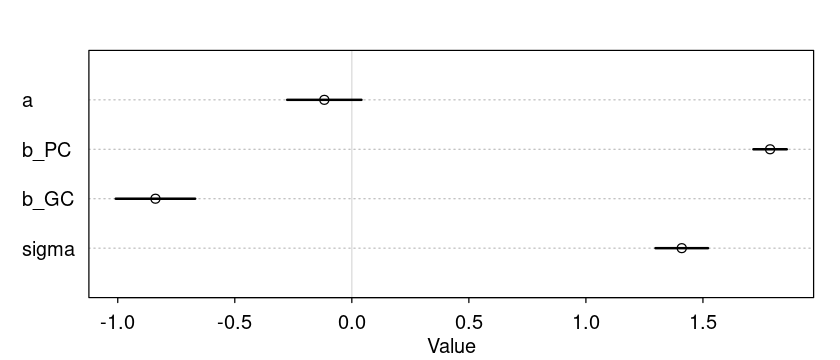

In [34]:
# R code 6.27
m6.11 <- quap(
 alist(
  C ~ dnorm(mu, sigma),
  mu <- a + b_PC*P + b_GC*G,
  a ~ dnorm(0 ,1),
  c(b_PC,b_GC) ~ dnorm(0, 1),
  sigma ~ dexp(1)
 ), data=d )
precis(m6.11)
plot(precis(m6.11))

+ Parents effect nearly twice as strong as it should be
+ Grandparents hurt Grandkids ! How does this occur?
+ Plot of standardized G eduction vs C education
+ Full set of points - Higher G means higher C
+ Conditioning on Parents is like looking at sub-groups of parents with similar education.
+ If we take a percentile sub group and draw the regression line it is negative
+ It is negative because once we condition on P learning G tells us about U, and U is associated with the outcome C

![alt text](images/6/parents-percentiles.png "Title")

+ To get over this, we have to measure U and also condition on U

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.12197510,0.07192588,-0.2369265,-0.007023655
b_PC,1.01161103,0.06597258,0.9061741,1.117047948
b_GC,-0.04081373,0.09728716,-0.1962974,0.114669941
b_U,1.99648992,0.14770462,1.7604294,2.232550439
sigma,1.01959911,0.05080176,0.9384081,1.100790130


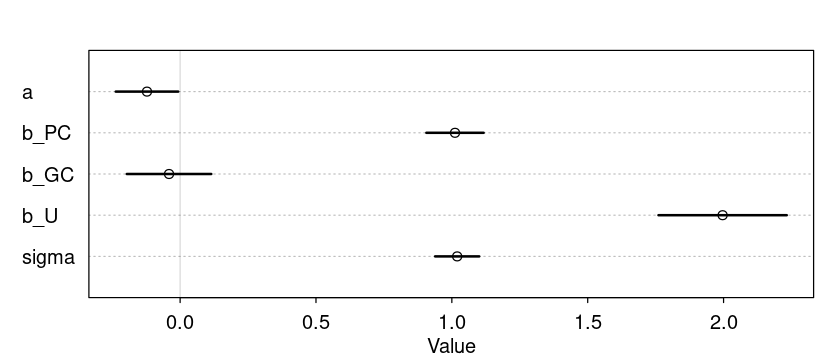

In [35]:
# R code 6.28
m6.12 <- quap(
 alist(
  C ~ dnorm(mu, sigma),
  mu <- a + b_PC*P + b_GC*G + b_U*U,
  a ~ dnorm(0, 1),
  c(b_PC,b_GC,b_U) ~ dnorm(0, 1),
  sigma ~ dexp(1)
 ), data=d )
precis(m6.12)
plot(precis(m6.12))

+ This regression gets back the original slopes:
    + b_GC <- 0 # direct effect of G on C
    + b_PC <- 1 # direct effect of P on C
    + b_U <- 2 # direct effect of U on P and C

# 6.4 Confronting Confounding

In [36]:
help(rnorm)

Normal {stats},R Documentation
"x, q",vector of quantiles.
p,vector of probabilities.
n,"number of observations. If length(n) > 1, the length is taken to be the number required."
mean,vector of means.
sd,vector of standard deviations.
"log, log.p","logical; if TRUE, probabilities p are given as log(p)."
lower.tail,"logical; if TRUE (default), probabilities are P[X \le x] otherwise, P[X > x]."
